In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix,print_matrix
from scripts_tempHelix import generate_static_temporal_helix
from scripts_theoreticalHittingTime import create_transition_matrix,expected_hitting_time

In [2]:
def estimate_hitting_time(n_values, start_vertex, end_vertex, num_simulations=10):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for n in n_values:
        print(f'\nCalculatig hitting time for n = {n}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = unique_edges_graph(n)
        current_node = list(graph.nodes)[start_vertex]
        if end_vertex == 'mid':
            end_node =n//2
        if end_vertex == '-1':
            end_node =n-1
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s==0 or s==1 or s==10 or s==25 or s==35 or s==49 or s==59 or s==69 or s==79 or s==89 or s==99:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1
                # print(current_node)
                # print(end_node)
                # print()

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times


In [3]:
n_range = list(range(3, 100))

samples = 100

initVertex = 0
targetVertex = '-1'

factor = 1
c = 1

hitting_times_file = f'Datasets/HTIrregularGraph/hittingTimeIrregularGraph_N{n_range[-1]}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    # theoretical_hitting_times = fit_hitting_time(n_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times = estimate_hitting_time(n_range,initVertex,targetVertex,samples)
    # theoretical_hitting_times = fit_hitting_time(n_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times)


Looking for: 
-----> Datasets/HTIrregularGraph/hittingTimeIrregularGraph_N99_FROM0-TO-1_S100.txt

File exists!


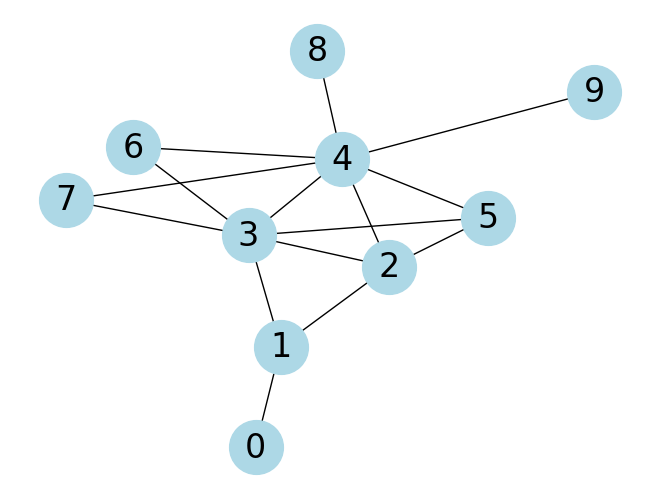

[[0 1 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0]
 [0 1 0 1 1 1 0 0 0 0]
 [0 1 1 0 1 1 1 1 0 0]
 [0 0 1 1 0 1 1 1 1 1]
 [0 0 1 1 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
[1, 3, 4, 6, 7, 3, 2, 2, 1, 1]


In [8]:

def vertex_degrees(graph):
    """
    Returns a list containing the degree of each vertex in the graph.
    
    Parameters:
    - graph (networkx.Graph or networkx.DiGraph): A networkx graph or digraph instance.

    Returns:
    - List[int]: List containing the degree of each vertex.
    """
    return [d for n, d in graph.degree()]

def unique_edges_graph(n_nodes):
    """
    Create a graph with `n_nodes` where each node has a unique number of edges.
    
    Parameters:
    - n_nodes: Number of nodes in the graph
    
    Returns:
    - G: A networkx Graph
    """
    if n_nodes <= 1:
        raise ValueError("The number of nodes should be greater than 1.")

    G = nx.Graph()
    total_edges = n_nodes * (n_nodes - 1) // 2  # n(n-1)/2 is the total number of edges for a complete graph of n nodes
    
    if total_edges < sum(range(n_nodes)):  # The total edges of complete graph should be >= sum of first n integers to ensure uniqueness
        raise ValueError(f"Cannot create a graph with {n_nodes} nodes where each has a unique number of edges.")

    # Start building the graph
    current_node = 0
    for i in range(1, n_nodes):
        for j in range(i):
            G.add_edge(current_node, current_node + 1 + j)
        current_node += 1

    return G

# Example usage
G = unique_edges_graph(6)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=1500, font_size=24)
plt.show() 

adjm = nx.adjacency_matrix(G).todense()
print(adjm)
deg = vertex_degrees(G)
print(deg)


In [5]:
def theoretical_hitting_time(P, init, target):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    # print(n)
    
    if target=='mid':
        target = n//2
        
    if target=='-1':
        target = n-1        
    order = list(range(n))
    order.remove(target)
    order.append(target)
    
    P = P[np.ix_(order, order)]
    # print_matrix(P)
    # print()
        
    P_prime = P[:-1, :-1]

    init_dist = np.zeros(n-1)
    init_dist[init] = 1
    
    target_dist = np.ones(n-1)

    I = np.eye(n-1)

    P_prime_inv = np.linalg.inv(I - P_prime)
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_inv, target_dist))

    return hitting_time

def theoretical_hitting_time2(P, init, target):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    # print(n)
    
    if target=='mid':
        target = n//2
    if target=='-1':
        target = n-1
    order = list(range(n))
    order.remove(target)
    order.append(target)
    
    P = P[np.ix_(order, order)]
    # print_matrix(P)
    # print()
        
    P_prime = P[:-1, :-1]

    init_dist = np.zeros(n-1).T
    init_dist[init] = 1
    
    target_dist = np.ones(n-1).T

    I = np.eye(n-1)

    P_prime_inv = np.linalg.inv(I - P_prime).T
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_inv, target_dist))

    return hitting_time

def theoretical_hitting_time3(P, init, target):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states
    # print(n)
    
    if target=='mid':
        target = n//2
    if target=='-1':
        target = n-1
    order = list(range(n))
    order.remove(target)
    order.append(target)
    
    P = P[np.ix_(order, order)]
    # print_matrix(P)
    # print()
        
    P_prime = P[:-1, :-1]

    init_dist = np.zeros(n-1).T
    init_dist[init] = 1
    
    target_dist = np.ones(n-1)

    I = np.eye(n-1)

    P_prime_inv = np.linalg.inv(I - P_prime).T
        
    hitting_time = np.dot(init_dist, np.dot(P_prime_inv, target_dist))

    return hitting_time

def theoretical_hitting_times_for_irregular_graphs(n_range, init, target):
    hitting_times = []
    for n in n_range:
            G = unique_edges_graph(n)
            P = create_transition_matrix(G)
            # print_matrix(P)
            # print()
            # nx.draw(np.ndarray(nx.from_numpy_array(P)))
            hitting_time = theoretical_hitting_time(P, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

def theoretical_hitting_times_for_irregular_graphs2(n_range, init, target):
    hitting_times = []
    for n in n_range:
            G = unique_edges_graph(n)

            P = create_transition_matrix(G)
            # print_matrix(P)
            # print()
            # nx.draw(np.ndarray(nx.from_numpy_array(P)))
            hitting_time = theoretical_hitting_time2(P, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

def theoretical_hitting_times_for_irregular_graphs3(n_range, init, target):
    hitting_times = []
    for n in n_range:
            G = unique_edges_graph(n)

            P = create_transition_matrix(G)
            # print_matrix(P)
            # print()
            # nx.draw(np.ndarray(nx.from_numpy_array(P)))
            hitting_time = theoretical_hitting_time3(P, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

 1 is equal to 2: False
 2 is equal to 3: True
 3 is equal to 1: False
97


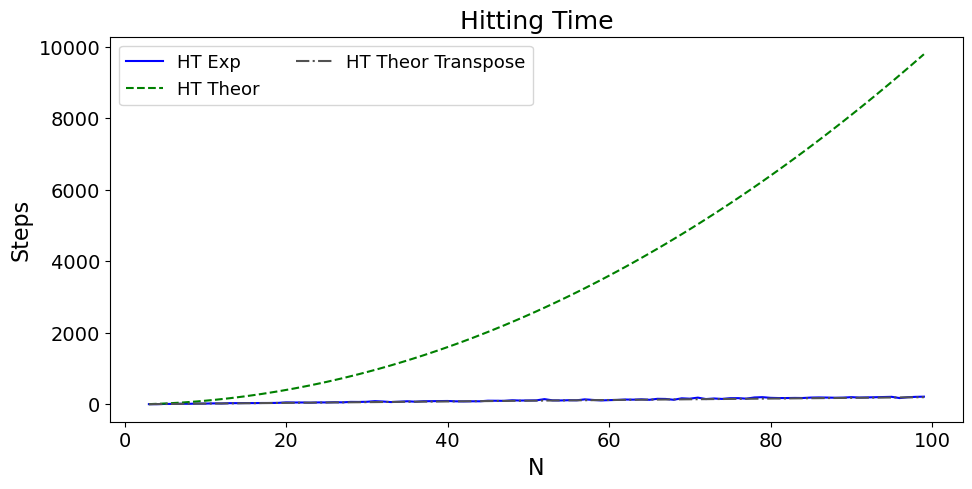

In [6]:
n_range = range(3, 100)

init = 0
target = '-1'

cw_weight=0.6
acw_weight=0.4

theoretical_hitting_times = theoretical_hitting_times_for_irregular_graphs(n_range, init, target)
theoretical_hitting_times2 = theoretical_hitting_times_for_irregular_graphs2(n_range, init, target)
theoretical_hitting_times3 = theoretical_hitting_times_for_irregular_graphs3(n_range, init, target)
# print(theoretical_hitting_times)
# print()
# print(theoretical_hitting_times2)
print(f' 1 is equal to 2: {theoretical_hitting_times ==theoretical_hitting_times2}' )
print(f' 2 is equal to 3: {theoretical_hitting_times2 ==theoretical_hitting_times3}' )
print(f' 3 is equal to 1: {theoretical_hitting_times3 ==theoretical_hitting_times}' )
# 
# theoretical_hitting_times_file = f'Datasets/HTDirectedCycle/theoreticalHittingTimeDirectedCycle_N{n_range[-1]}_CWWEIGHT{cw_weight}_ACWWEIGHT{acw_weight}_FROM{initVertex}-TO{targetVertex}.txt'

# print(f'Looking for: \n-----> {theoretical_hitting_times_file}')

# if os.path.exists(theoretical_hitting_times_file):
#     theoretical_hitting_times = load_list_from_file(theoretical_hitting_times_file)
#     print('\nFile exists!')
# else:
#     print('\nFile Doesnt Exist!')
#     theoretical_hitting_times =  theoretical_hitting_times_for_cycle_graphs(n_range, init, target,cw_weight,acw_weight)
#     write_list_to_file(theoretical_hitting_times_file, theoretical_hitting_times)

# alphaLabelList = [r'HT Exp',r'HT Theor1',f'HT Theor2']
alphaLabelList = [f'HT Exp',r'HT Theor',f'HT Theor Transpose']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}

y_value_list = [
                hitting_times,
                theoretical_hitting_times,
                theoretical_hitting_times2
               ]

# print(len(hitting_times3))
print(len(theoretical_hitting_times))
plot_qwak(x_value_matrix = [list(n_range)]*len(y_value_list) , y_value_matrix = y_value_list ,**params)

97


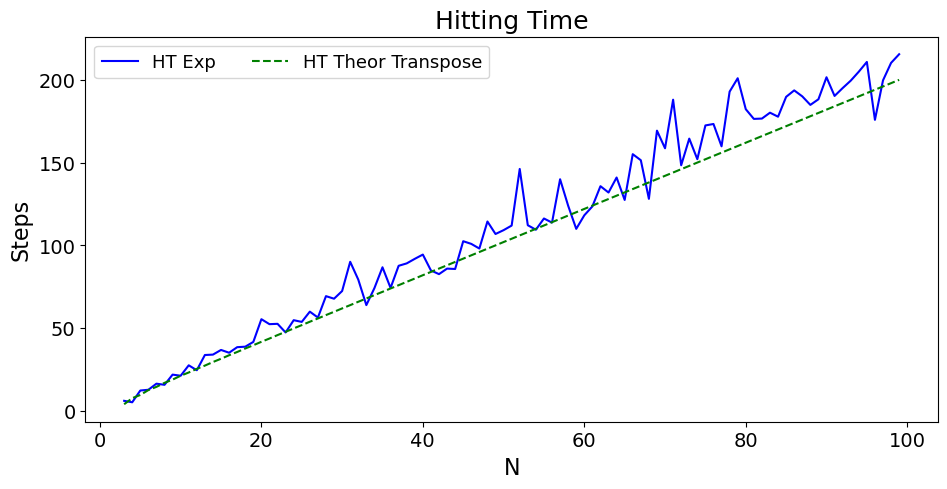

In [7]:
n_range = range(3, 100)

init = 0
target = '-1'

cw_weight=0.6
acw_weight=0.4

theoretical_hitting_times = theoretical_hitting_times_for_irregular_graphs(n_range, init, target)
theoretical_hitting_times2 = theoretical_hitting_times_for_irregular_graphs2(n_range, init, target)
theoretical_hitting_times3 = theoretical_hitting_times_for_irregular_graphs3(n_range, init, target)
# print(theoretical_hitting_times)
# print()
# print(theoretical_hitting_times2)
# print(f' 1 is equal to 2: {theoretical_hitting_times ==theoretical_hitting_times2}' )
# print(f' 2 is equal to 3: {theoretical_hitting_times2 ==theoretical_hitting_times3}' )
# print(f' 3 is equal to 1: {theoretical_hitting_times3 ==theoretical_hitting_times}' )
# 
# theoretical_hitting_times_file = f'Datasets/HTDirectedCycle/theoreticalHittingTimeDirectedCycle_N{n_range[-1]}_CWWEIGHT{cw_weight}_ACWWEIGHT{acw_weight}_FROM{initVertex}-TO{targetVertex}.txt'

# print(f'Looking for: \n-----> {theoretical_hitting_times_file}')

# if os.path.exists(theoretical_hitting_times_file):
#     theoretical_hitting_times = load_list_from_file(theoretical_hitting_times_file)
#     print('\nFile exists!')
# else:
#     print('\nFile Doesnt Exist!')
#     theoretical_hitting_times =  theoretical_hitting_times_for_cycle_graphs(n_range, init, target,cw_weight,acw_weight)
#     write_list_to_file(theoretical_hitting_times_file, theoretical_hitting_times)

alphaLabelList = [r'HT Exp',f'HT Theor Transpose']


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 2,
    'color_list' : ['#0000FF', '#008000', '#525252','red','#eb4034','#8f82f1'],
    'line_style_list' : ['-', '--','-.',':','-','-.'],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
}

y_value_list = [
                hitting_times,
                theoretical_hitting_times2
               ]

# print(len(hitting_times3))
print(len(theoretical_hitting_times))
plot_qwak(x_value_matrix = [list(n_range)]*len(y_value_list) , y_value_matrix = y_value_list ,**params)